In [35]:
# Imports needed in every section
import pandas as pd
#import testing_scripts.constants as constants
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, confusion_matrix

#Read Data
df = pd.read_csv('oct_data.csv', index_col=0)

## Motivating Figures (Section 3)

### Figure 1-A (Resume Scores Across Different LLMs)

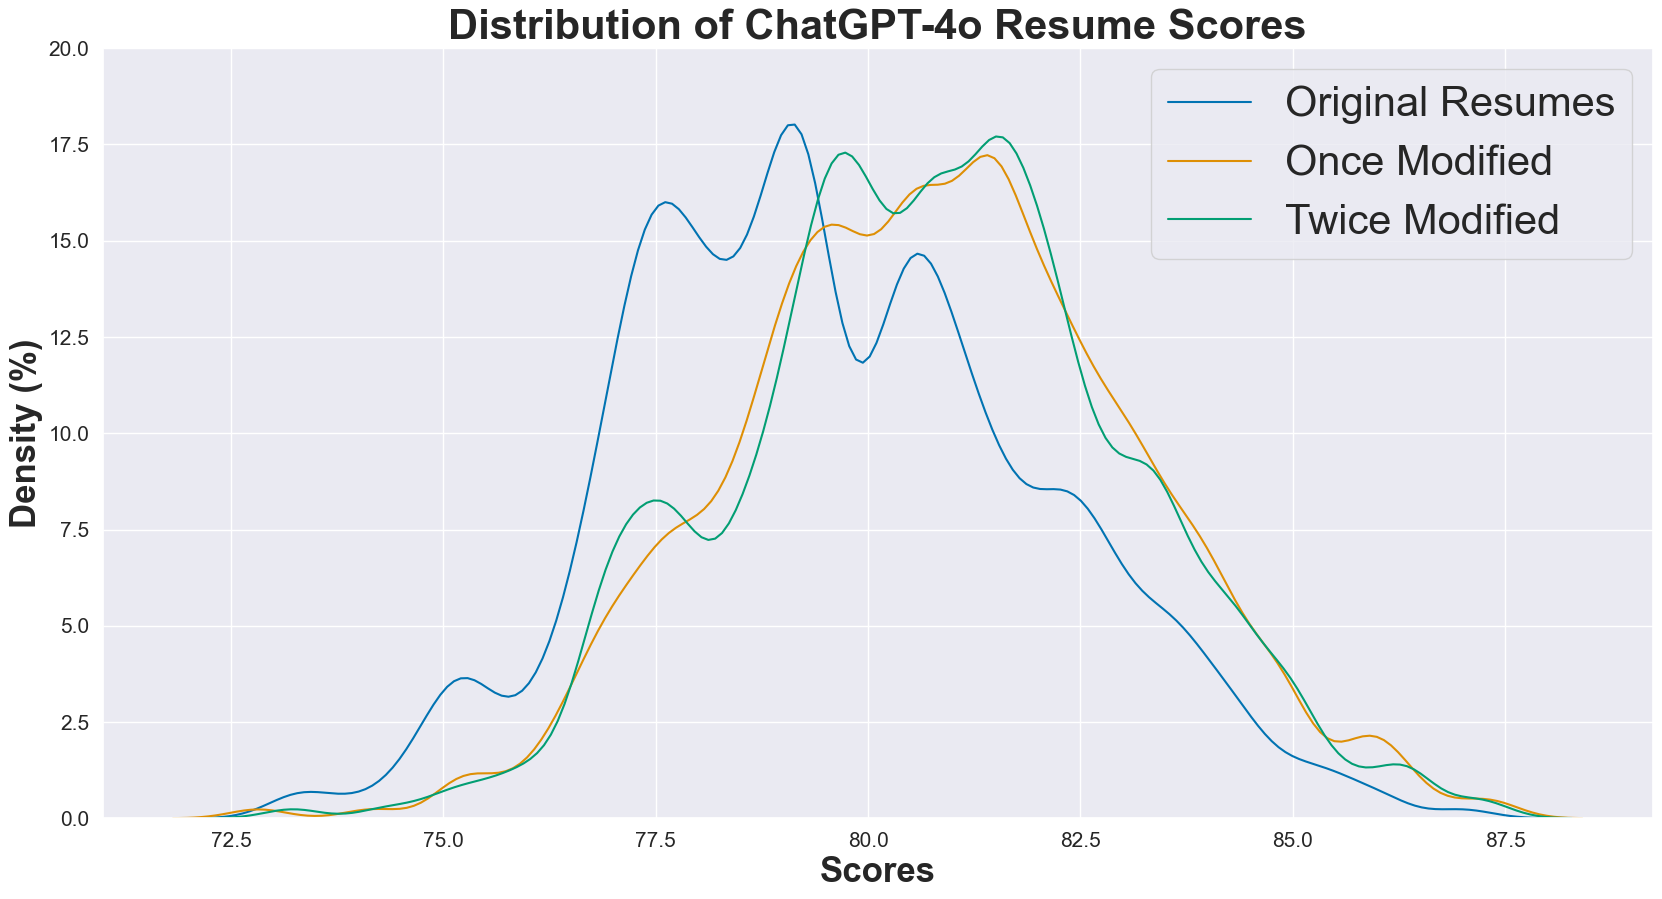

In [297]:
sns.set_theme(rc={'figure.figsize':(20,10)})

fig = sns.kdeplot(df['CVDoorDash PM Score'], bw_adjust=0.5, color=first_three_colors[0])  # bw_adjust adjusts the smoothness
fig = sns.kdeplot(df['Cleaned GPT-4o Conversation-Improved CVDoorDash PM Score'], bw_adjust=0.5, color=first_three_colors[1])
#sns.kdeplot(df['CVDoorDash PM Score'], bw_adjust=0.5)  # bw_adjust adjusts the smoothness
fig = sns.kdeplot(df['Cleaned Twice GPT-4o Conversation-Improved CVDoorDash PM Score'], bw_adjust=0.5, color=first_three_colors[2])
plt.title('Distribution of ChatGPT-4o Resume Scores', fontsize=30, fontweight="bold")
plt.yticks(fig.get_yticks(), np.round(fig.get_yticks() * 100, 2))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Scores', fontsize=25, fontweight="bold")
plt.ylabel('Density (%)', fontsize=25, fontweight="bold")
plt.legend(['Original Resumes', 'Once Modified', 'Twice Modified'], fontsize=30)
#plt.grid()
plt.savefig('chatgpt1.png')
plt.show()

### Figure 1-B (Resume Scores over Sequential LLM Manipulations)

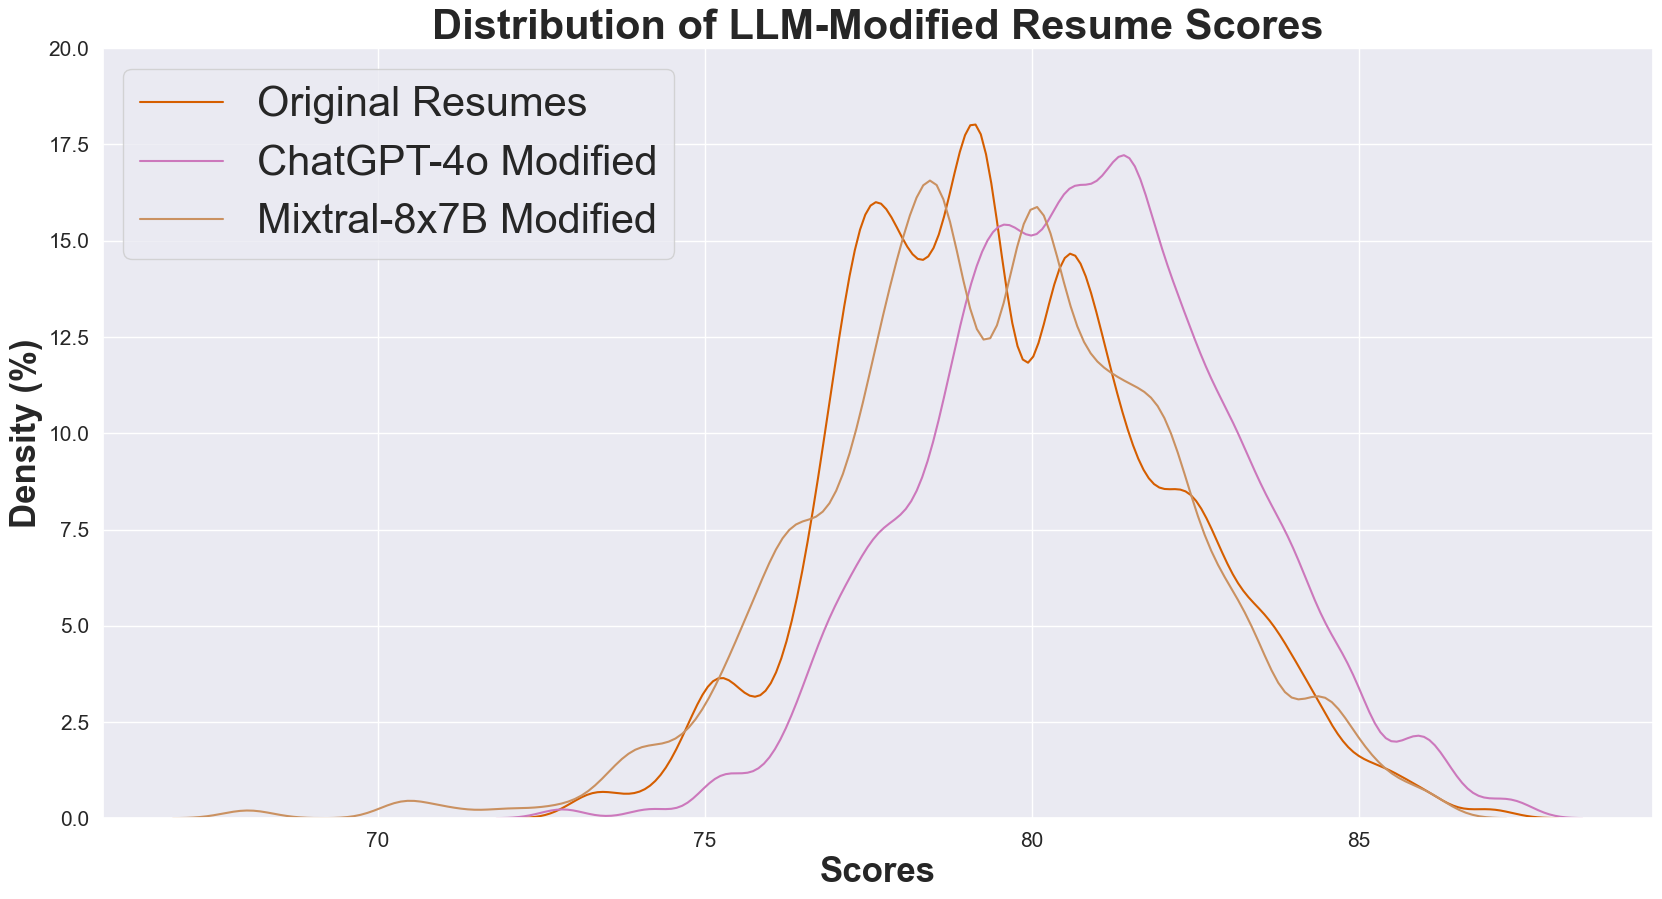

In [302]:
sns.set_theme(rc={'figure.figsize':(20,10)})
sns.kdeplot(df['CVDoorDash PM Score'], bw_adjust=0.5, color=next_three[0])  # bw_adjust adjusts the smoothness
sns.kdeplot(df['Cleaned GPT-4o Conversation-Improved CVDoorDash PM Score'], bw_adjust=0.5, color=next_three[1])
#sns.kdeplot(df['CVDoorDash PM Score'], bw_adjust=0.5)  # bw_adjust adjusts the smoothness
sns.kdeplot(df['Cleaned Together Conversation-Improved CVDoorDash PM Score'], bw_adjust=0.5, color=next_three[2])
plt.title('Distribution of LLM-Modified Resume Scores', fontsize=30,fontweight="bold")
plt.xlabel('Scores', fontsize=25, fontweight="bold")
plt.yticks(fig.get_yticks(), np.round(fig.get_yticks() * 100, 2))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Density (%)', fontsize=25, fontweight="bold")
plt.legend(['Original Resumes', 'ChatGPT-4o Modified', 'Mixtral-8x7B Modified'], fontsize=30)# fontweight="bold")
#plt.grid()
plt.savefig("differentllms1.png")
plt.show()

## Outcome Metrics

In [19]:
print("Average ChatGPT-4o Improvements on Original, Unmodified Resumes (1 Iteration) & 96% Confidence Interval")
print(str(np.mean(df['Cleaned GPT-4o Conversation-Improved CVDoorDash PM Score'] - df['CVDoorDash PM Score'])) + " +/ "+ str(1.96*np.std(df['Cleaned GPT-4o Conversation-Improved CVDoorDash PM Score'] - df['CVDoorDash PM Score'])/22.2))

Average ChatGPT-4o Improvements on Original, Unmodified Resumes (1 Iteration) & 96% Confidence Interval
1.1881384615384614 +/ 0.13791601426489786


## Experimental Results (See Section 8 of Paper)

In [23]:
'''
The following functions replicates how original resume scores are mapped to applicant reported 
and hirer inputted scores according to our traditional and two-ticket hiriing schemes, respectively.
'''

# Function that takes in choice amongst original & modified resume scores, and reports Applicant submitted scores. 
# These inputs are equivalent to the datapoints a traditional hiring system would consider.
def map_input_score(row):
    if row['Will Manipulate']:
        #If applicant is manipulating, will report better performing score amongst original and modified resume.
        return max(row['CVDoorDash PM Score'], row['Cleaned GPT-4o Conversation-Improved CVDoorDash PM Score'])
    else:
        #If application is not manipulating, applicant can only report original score.
        return row['CVDoorDash PM Score']

# Function that takes in choice amongst original & modified resume scores, and reports Hirer inputted scores. Considers a modified version against the submitted resume.
def map_hirer_score(row):
    if row['Will Manipulate']:
        #If applicant has manipulated previously, take maximum of submitted score and 'twice' modified resume score.
        return max(row['input_score'], row['Cleaned Twice GPT-4o Conversation-Improved CVDoorDash PM Score'])
    else:
        #If applicant has not manipulated previously, take maximum of submitted score and 'once' modified resume score.
        return max(row['input_score'], row['Cleaned GPT-4o Conversation-Improved CVDoorDash PM Score'])

# Assuming your DataFrame is named 'df'
df['input_score'] = df.apply(map_input_score, axis=1)
df['hirer_score'] = df.apply(map_hirer_score, axis=1)
# Check statistics
df.groupby('True Label')[['input_score', 'hirer_score']].describe()

input_score                                                 \
                 count       mean       std     min       25%     50%   
True Label                                                              
0                260.0  79.072608  2.039091  73.895  77.69050  79.072   
1                260.0  81.293404  2.489718  73.121  79.72075  81.390   

                             hirer_score                               \
                 75%     max       count       mean       std     min   
True Label                                                              
0           80.48825  86.701       260.0  79.963765  1.836395  76.001   
1           83.13275  86.998       260.0  82.122512  2.207033  73.121   

                                                
                 25%      50%      75%     max  
True Label                                      
0           78.73025  79.9340  81.1080  86.701  
1           80.73800  82.2345  83.6825  87.404

In [22]:
'''
The following Functions help us calculate optimal thresholds according to our "No False Positives Objective" on the training sets.
in each iteration of our sampling test to generate an estimate for the our TPR and disparity improvements across Traditional and "Two-Ticket" Hiring.
'''

#Function that calculates the threshold according to an approximation our 'no-False Positives" objective.
#In other words, we want to find a threshold that maximizes the TPR but sets the FPR arbitrarily small (not zero, but sufficiently close).
def set_threshold_min_fpr(scores, labels, min_tpr=0.01):
    # Ensure scores and labels are numpy arrays
    scores = np.array(scores)
    labels = np.array(labels)

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(labels, scores)

    # Find the index where TPR is just above min_tpr
    valid_idx = np.where(tpr >= min_tpr)[0]
    if len(valid_idx) > 0:
        best_idx = valid_idx[0]
        return thresholds[best_idx], fpr[best_idx], tpr[best_idx]
    else:
        # If no threshold gives TPR >= min_tpr, return the threshold with highest TPR
        best_idx = np.argmax(tpr)
        return thresholds[best_idx], fpr[best_idx], tpr[best_idx]

#Function that calculates the threshold according to an approximation our 'no-False Positives" objective.
#In other words, we want to find a threshold that maximizes the TPR but sets the FPR to zero.
def set_threshold_zero_fpr(scores, labels):
    # Ensure scores and labels are numpy arrays
    scores = np.array(scores)
    labels = np.array(labels)

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(labels, scores)
    #print(fpr, tpr, thresholds)
    # Find the index of the first non-zero false positive rate
    zero_fpr_index = np.argwhere(fpr > 0)[0][0] - 1

    # Get the threshold that gives zero false positive rate
    threshold = thresholds[zero_fpr_index]

    return threshold

In [29]:
""" The following functions help us calculate our neccesary metrics on the testing set: namely, the disparity, TPR, FNR, & Accuracy."""
def calculate_disparity(y_true, y_pred, y_manipulate_label):

    y_true_a = [y_true[i] for i in range(len(y_manipulate_label)) if y_manipulate_label[i]==True]
    y_pred_a = [y_pred[i] for i in range(len(y_manipulate_label)) if y_manipulate_label[i]==True]

    y_true_b = [y_true[i] for i in range(len(y_manipulate_label)) if y_manipulate_label[i]==False]
    y_pred_b = [y_pred[i] for i in range(len(y_manipulate_label)) if y_manipulate_label[i]==False]
    #print(np.mean(y_true_a), np.mean(y_true_b))
    #print(len(y_true_a), len(y_true_b))
    tn_a, fp_a, fn_a, tp_a = confusion_matrix(y_true_a, y_pred_a).ravel()
    tn_b, fp_b, fn_b, tp_b = confusion_matrix(y_true_b, y_pred_b).ravel()

    tpr_a = tp_a/(tp_a + fn_a)
    tpr_b = tp_b/(tp_b + fn_b)
    return tpr_a - tpr_b

def calculate_tpr_fnr_accuracy(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn)
    fnr = fn / (fn + tp)
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    return tpr, fnr, accuracy

In [34]:
num_iter = 500
results = []

#Repeat our experiment num_iter times: each experiment has resamples a new train-test split.
for i in range(num_iter):

  #Conduct the train-test split.
  train_df = df.sample(frac=0.6, random_state=i)
  test_df = df.drop(train_df.index)

  ## Calculate Traditional-Threshold with One Ticket
  threshold, train_fpr, train_tpr = set_threshold_min_fpr(train_df['input_score'], train_df['True Label'])

  #Get Predictions of Traditional Classifier on Test Set from Above Threshold. 
  test_predictions_1ticket = [1 if score >= threshold else 0 for score in test_df['input_score']]
  test_labels = test_df['True Label'].values
  test_manipulate_label = test_df['Will Manipulate'].values

  #Get Predictions of Two Ticket Classifier on Test Set from Above Threshold. 
  test_predictions_2ticket = [1 if score >= threshold else 0 for score in test_df['hirer_score']]
  test_labels = test_df['True Label'].values

  # Calculate Metrics of Traditional Classifier on Test Set.
  test_tpr_1ticket, test_fnr_1ticket, test_accuracy_1ticket = calculate_tpr_fnr_accuracy(test_labels, test_predictions_1ticket)
  test_disparity_1_ticket = calculate_disparity(test_labels, test_predictions_1ticket, test_manipulate_label)
  #print(f"True Positive Rate on 1 ticket test set: {test_tpr_1ticket:.2f}")

  # Calculate Metrics of Two Ticket Classifier on Test Set.
  test_tpr_2ticket, test_fnr_2ticket, test_accuracy_2ticket = calculate_tpr_fnr_accuracy(test_labels, test_predictions_2ticket)
  test_disparity_2_ticket = calculate_disparity(test_labels, test_predictions_2ticket, test_manipulate_label)

  #Append Metrics of classifiers, per iteration to our final collected data.
  results.append({
    'test_accuracy_1ticket': test_accuracy_1ticket,
    'test_accuracy_2ticket': test_accuracy_2ticket,
    #Get the pairwise difference in accuracy between the two ticket and traditional classifier for each iteration (results in our paper's table).
    'test_accuracy_improvement': test_accuracy_2ticket-test_accuracy_1ticket,

    'test_tpr_1ticket': test_tpr_1ticket,
    'test_tpr_2ticket': test_tpr_2ticket,
    #Get the pairwise difference in TPR between the two ticket and traditional classifier for each iteration (results in our paper's table).
    'tpr_improvement':  test_tpr_2ticket-test_tpr_1ticket,

    'test_disparity_1ticket': test_disparity_1_ticket,
    'test_disparity_2_ticket': test_disparity_2_ticket,
    #Get the pairwise difference in disparity between the two ticket and traditional classifier for each iteration (results in our paper's table).
    'disparity_decrease_2_1':  test_disparity_1_ticket-test_disparity_2_ticket,
                 
    'Threshold': threshold,
    'train_fpr': train_fpr,
    'train_tpr': train_tpr,
                  
    'test_fnr_1ticket': test_fnr_1ticket,
    'test_fnr_2ticket': test_fnr_2ticket,
    'num_accepted_1ticket': sum(test_predictions_1ticket),
    'num_accepted_2ticket': sum(test_predictions_2ticket),
    'tpr_improvement_b': True if test_tpr_2ticket - test_tpr_1ticket > 0 else False,
                  
  })

In [31]:
results_df = pd.DataFrame(results)
results_df.describe()

,test_accuracy_1ticket,test_accuracy_2ticket,test_accuracy_improvement,test_tpr_1ticket,test_tpr_2ticket,tpr_improvement,test_disparity_1ticket,test_disparity_2_ticket,disparity_decrease_2_1,Threshold,train_fpr,train_tpr,test_fnr_1ticket,test_fnr_2ticket,num_accepted_1ticket,num_accepted_2ticket
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.553510,0.574298,0.020788,0.112987,0.164622,0.051635,0.103595,0.066347,0.037248,84.301942,0.004017,0.118061,0.887013,0.835378,12.636000,19.008000
std,0.033984,0.038508,0.012404,0.050614,0.068005,0.024100,0.056813,0.060264,0.037513,0.467547,0.003114,0.045782,0.050614,0.068005,5.894488,7.932072
min,0.456731,0.490385,-0.009615,0.026786,0.049505,0.000000,-0.030702,-0.076342,-0.049663,82.902000,0.000000,0.033113,0.707547,0.594340,3.000000,6.000000
25%,0.528846,0.543269,0.013221,0.070132,0.108710,0.033613,0.064390,0.025042,0.012008,83.815000,0.000000,0.080345,0.843137,0.775701,8.000000,12.000000
50%,0.552885,0.572115,0.019231,0.099505,0.141414,0.048077,0.098240,0.060774,0.037061,84.705000,0.006211,0.097482,0.900495,0.858586,11.000000,16.000000
75%,0.576923,0.602163,0.028846,0.156863,0.224299,0.067838,0.137217,0.105565,0.059330,84.705000,0.006452,0.159509,0.929868,0.891290,17.250000,26.000000
max,0.653846,0.682692,0.062500,0.292453,0.405660,0.141414,0.279762,0.266176,0.185208,84.998000,0.007246,0.253425,0.973214,0.950495,37.000000,51.000000
